# Multi-Omics Imputation

The plan is to do the following:
- Divide the data into train, validation, and test sets. Leave the test set for later.
- Remove the values for a certain omics type from the validation set
- Impute using the train set and the remaining value in the validation set
- Compare these imputed values against the true values
    - Distribution of correlation coefficients
    - Get the mean and stdev of the correlation coefficients
    - Choose best model
- Evaluate on test set
- Choose best method
- Try on independent set
- Finally, train GCN model and see difference between single omics, multi-omics, and imputed multi-omics

I'll first start with some basics: data import and processing.
Then I'll move to imputing one omics from two.
Then I'll move to imputing two omics from one.
I'll do all the steps above along the way.

## Importing requisite packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from metrics import *

## Importing data

In [2]:
mrna = pd.read_csv("../R/TCGA BRCA/mrna_top1000.csv", index_col=0)
meth = pd.read_csv("../R/TCGA BRCA/meth_top1000.csv", index_col=0)
mirna = pd.read_csv("../R/TCGA BRCA/mirna_anova.csv", index_col=0)

labels = pd.read_csv("../R/TCGA BRCA/PAM50_subtype.csv", index_col=0)

## Basic Data Processing

Just combining all data and then also having a list containing what datatype the columns belong to.

In [3]:
all_data = pd.merge(pd.merge(mrna, meth, left_index=True, right_index=True), mirna,  left_index=True, right_index=True)

datatypes = ["mrna"]*mrna.shape[1] + ["meth"]*meth.shape[1] + ["mirna"]*mirna.shape[1]

In [4]:
all_data = (all_data-all_data.min())/(all_data.max() - all_data.min())
all_data.head()

,DBF4|10926,DACH1|1602,BBS4|585,L3MBTL4|91133,TK1|7083,KIAA1370|56204,GPD1L|23171,RERG|85004,RAPGEF3|10411,FBXO36|130888,...,hsa-mir-217,hsa-mir-424,hsa-mir-581,hsa-mir-483,hsa-mir-3614,hsa-mir-16-1,hsa-mir-550a-2,hsa-mir-24-1,hsa-mir-508,hsa-mir-642a
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A1XU-01,0.277770,0.758159,0.378836,0.356571,0.434890,0.554010,0.492860,0.812734,0.599057,0.787462,...,0.004411,0.078464,0.3125,0.002911,0.001617,0.059937,0.046753,0.256461,0.010449,0.070690
TCGA-D8-A1XV-01,0.513189,0.830736,0.648579,0.674419,0.566643,0.889481,0.607707,0.797190,0.454187,0.844195,...,0.003170,0.012424,0.1250,0.000333,0.002426,0.082900,0.038961,0.037773,0.003380,0.032759
TCGA-E9-A1N3-01,0.509665,1.000000,0.553200,0.152295,0.632370,0.669888,0.497003,0.789170,0.553367,0.915498,...,0.003446,0.044661,0.6875,0.000832,0.002426,0.063510,0.049351,0.093439,0.053473,0.110345
TCGA-C8-A1HE-01,0.362294,0.879097,0.601582,0.283353,0.540255,0.786171,0.813419,0.758284,0.668789,0.885250,...,0.001792,0.057869,0.1250,0.001248,0.004448,0.066019,0.007792,0.041750,0.001537,0.044828
TCGA-A1-A0SQ-01,0.429836,0.693130,0.505465,0.292312,0.608069,0.628752,0.616969,0.737191,0.509752,0.708378,...,0.001103,0.005261,0.0625,0.000083,0.003235,0.010478,0.005195,0.009940,0.000615,0.155172


In [5]:
labels.head()

,cancer_subtype
patient_id,
TCGA-D8-A1XU-01,LumA
TCGA-D8-A1XV-01,LumA
TCGA-E9-A1N3-01,LumA
TCGA-C8-A1HE-01,LumA
TCGA-A1-A0SQ-01,LumA


Doing the train-validation-test split.
These contain all the values intact.  

Here, we do a 60-20-20 split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42, stratify = y_train)


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

#all_data.head()
#labels.head()
#X_train.head()
#y_train.head()

(372, 2257)
(125, 2257)
(125, 2257)
(372, 1)
(125, 1)
(125, 1)


Removing all miRNA feature values

In [7]:
#Keeping values for later
from copy import deepcopy
X_test_truth = deepcopy(X_test)
X_val_truth = deepcopy(X_val)

mask = [x=="mirna" for x in datatypes]
X_test.loc[:,mask] = np.nan
X_val.loc[:,mask] = np.nan

X_test.loc[:,mask].head()

/home/bs16b001/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/bs16b001/.local/lib/python3.7/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,hsa-mir-576,hsa-mir-200b,hsa-mir-3687,hsa-mir-126,hsa-mir-26a-2,hsa-mir-101-1,hsa-mir-218-2,hsa-mir-223,hsa-mir-335,hsa-mir-1468,...,hsa-mir-217,hsa-mir-424,hsa-mir-581,hsa-mir-483,hsa-mir-3614,hsa-mir-16-1,hsa-mir-550a-2,hsa-mir-24-1,hsa-mir-508,hsa-mir-642a
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A3XX-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-BH-A0DI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-A7-A6VX-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-BH-A0AZ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-AR-A1AX-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simple Imputation Methods

In [8]:
from sklearn.impute import SimpleImputer

#Combining the train and test samples into one dataframe.
print(X_train.shape)
print(X_val.shape)
X = pd.concat([X_train, X_val])
print(X.shape)
X.iloc[370:375, mask]

(372, 2257)
(125, 2257)
(497, 2257)


,hsa-mir-576,hsa-mir-200b,hsa-mir-3687,hsa-mir-126,hsa-mir-26a-2,hsa-mir-101-1,hsa-mir-218-2,hsa-mir-223,hsa-mir-335,hsa-mir-1468,...,hsa-mir-217,hsa-mir-424,hsa-mir-581,hsa-mir-483,hsa-mir-3614,hsa-mir-16-1,hsa-mir-550a-2,hsa-mir-24-1,hsa-mir-508,hsa-mir-642a
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A1JB-01,0.079457,0.046150,0.008850,0.152926,0.099120,0.103930,0.080421,0.056304,0.022416,0.021445,...,0.000965,0.101410,0.0000,0.007236,0.002022,0.022180,0.033766,0.055666,0.006146,0.005172
TCGA-D8-A1JL-01,0.110465,0.138854,0.017699,0.097901,0.139139,0.027866,0.097684,0.076584,0.062983,0.020316,...,0.115024,0.202149,0.5625,0.000250,0.020218,0.083382,0.033766,0.236581,0.003688,0.008621
TCGA-EW-A2FS-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-BH-A8FZ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-D8-A1XG-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputing with Mean and Median

### Imputing with Mean

In [9]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

mean_imputed = imp.transform(X_val)
# SimpleImputers returns a numpy.ndarray
# I will convert it to a pandas data frame
#mean_imputed = pd.DataFrame(mean_imputed, columns = X_val.columns, index = X_val.index)


#print(mean_imputed.shape)
#mask = [x=="mirna" for x in datatypes]
#mean_imputed.loc[:,mask].head()

### Imputing with Median

In [10]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)

median_imputed = imp.transform(X_val)
#median_imputed = pd.DataFrame(median_imputed, columns = X_val.columns, index = X_val.index)

#print(median_imputed.shape)
#mask = [x=="mirna" for x in datatypes]
#median_imputed.loc[:,mask].head()

In [11]:
mask = [x=="mirna" for x in datatypes]
truth = X_val_truth.loc[:,mask].to_numpy()
random = (np.random.rand(truth.shape[0],truth.shape[1]))# - np.mean(truth))/np.std(truth)

print("RMSE")
print(rmse(truth, truth))
print(rmse(truth, random))
print(rmse(truth, mean_imputed[:,mask]))
print(rmse(truth, median_imputed[:,mask]))

print("\nStandard Deviation")
print(truth.std())
print(random.std())
print(mean_imputed[:,mask].std())
print(median_imputed[:,mask].std())

RMSE
0.0
0.5318593983648312
0.09808654721684143
0.10037655901358895

Standard Deviation
0.10615528918894765
0.2888251657885297
0.04489987012416516
0.03600215901869758


# Slightly More Complicated Methods

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Here, initially, all the missing features are replaced with the mean value. Then, iteratively, the estimator is used to estimate the missing value from all the other features. Within each iteration through all the missing values, the features are imputed in a random order.

## Estimator: ElasticNet

#### L1 Ratio = 0.2

In [13]:
from sklearn.linear_model import ElasticNet

imp = IterativeImputer(estimator = ElasticNet(l1_ratio = 0.2), initial_strategy = "mean", 
                       imputation_order = "random", random_state = 42,
                      n_nearest_features = 50)
imp.fit(X_train)

elasticnet_l2_imputed = imp.transform(X_val)
#elasticnet_l2_imputed = pd.DataFrame(elasticnet_l2_imputed, columns = X_val.columns, index = X_val.index)
#print(elasticnet_l2_imputed.shape)
#mask = [x=="mirna" for x in datatypes]
#elasticnet_l2_imputed.loc[:,mask].head()

#### L1 Ratio = 0.8

In [14]:
from sklearn.linear_model import ElasticNet

imp = IterativeImputer(estimator = ElasticNet(l1_ratio = 0.75), initial_strategy = "mean", 
                       imputation_order = "random", random_state = 42,
                      n_nearest_features = 50)
imp.fit(X_train)

elasticnet_l1_imputed = imp.transform(X_val)
#elasticnet_l1_imputed = pd.DataFrame(elasticnet_l1_imputed, columns = X_val.columns, index = X_val.index)
#print(elasticnet_l1_imputed.shape)
#mask = [x=="mirna" for x in datatypes]
#elasticnet_l1_imputed.loc[:,mask].head()

In [15]:
print("RMSE")
print(rmse(truth, truth))
print(rmse(truth, mean_imputed[:,mask]))
print(rmse(truth, elasticnet_l1_imputed[:,mask]))
print(rmse(truth, elasticnet_l2_imputed[:,mask]))

print("\nStandard Deviation")
print(truth.std())
print(mean_imputed[:,mask].std())
print(elasticnet_l1_imputed[:,mask].std())
print(elasticnet_l2_imputed[:,mask].std())

RMSE
0.0
0.09808654721684143
0.09808654721684143
0.09808654721684143

Standard Deviation
0.10615528918894765
0.04489987012416516
0.04489987012416516
0.04489987012416516


## Estimator: KNeighborsRegressor

#### K = 25

In [42]:
from sklearn.neighbors import KNeighborsRegressor

imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=25), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 25)
imp.fit(X_train)

knn25_iter_imputed = imp.transform(X_val)

#### K = 50

In [43]:
from sklearn.neighbors import KNeighborsRegressor

imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=50), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 50)
imp.fit(X_train)

knn50_iter_imputed = imp.transform(X_val)

#### K = 75

In [44]:
from sklearn.neighbors import KNeighborsRegressor

imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=75), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 75)
imp.fit(X_train)

knn75_iter_imputed = imp.transform(X_val)

#### K = 100

In [45]:
from sklearn.neighbors import KNeighborsRegressor

imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=100), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 100)
imp.fit(X_train)

knn100_iter_imputed = imp.transform(X_val)

In [46]:
print("RMSE")
print(rmse(truth, truth))
print(rmse(truth, mean_imputed[:,mask]))
print(rmse(truth, knn25_iter_imputed[:,mask]))
print(rmse(truth, knn50_iter_imputed[:,mask]))
print(rmse(truth, knn75_iter_imputed[:,mask]))
print(rmse(truth, knn100_iter_imputed[:,mask]))

print("\nStandard Deviation")
print(truth.std())
print(mean_imputed[:,mask].std())
print(knn25_iter_imputed[:,mask].std())
print(knn50_iter_imputed[:,mask].std())
print(knn75_iter_imputed[:,mask].std())
print(knn100_iter_imputed[:,mask].std())

RMSE
0.0
0.09808654721684143
0.09706443121270594
0.09684563410179363
0.09688083879202193
0.09683528846469257

Standard Deviation
0.10615528918894765
0.04489987012416516
0.04442395037412617
0.04136561038910045
0.04102801872375675
0.040607221785942914


## Estimator: RandomForestRegressor

#### Max Depth = 10

In [11]:
from sklearn.ensemble import RandomForestRegressor

imp = IterativeImputer(estimator = RandomForestRegressor(max_depth=10), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 200)
imp.fit(X_train)

rf10_imputed = imp.transform(X_val)

#### Max Depth = 20

In [12]:
from sklearn.ensemble import RandomForestRegressor

imp = IterativeImputer(estimator = RandomForestRegressor(max_depth=20), 
                       initial_strategy = "mean", imputation_order = "random", random_state = 42,
                      n_nearest_features = 200)
imp.fit(X_train)

rf20_imputed = imp.transform(X_val)

In [13]:
print(nrmse(truth, mean_imputed[:,mask]))
print(nrmse(truth, rf10_imputed[:,mask]))
print(nrmse(truth, rf20_imputed[:,mask]))

1.3514235544024777
1.3526947398648599
1.353721124349755


# Deck Imputation

It is not exactly deck imputation in that we are not replacing the missing value with a value from the existing set. Here, I select the k closest samples and get the average of their values to impute the missing values.

I am testing kNN with k values equal to all odd numbers between 0 and 20.

In [14]:
from sklearn.impute import KNNImputer

knn = {}

for i in [1,5,10,15,20,25,30,35,40,45,50,75,100]:
    imputer = KNNImputer(n_neighbors=i)
    imputer.fit(X_train)

    knn[i] = imputer.transform(X_val)
    #knn[i] = pd.DataFrame(knn[i], columns = X_val.columns, index = X_val.index)

print(len(knn))
#print(knn[1].shape)
#mask = [x=="mirna" for x in datatypes]
#knn[1].loc[:,mask].head()

13


In [16]:
print(rmse(truth, truth))
print(truth.std())
print()
print(rmse(truth, mean_imputed[:,mask]))
print(mean_imputed[:,mask].std())
print()

print(min([rmse(truth, each[:,mask]) for each in knn.values()]))
print(max([each[:,mask].std() for each in knn.values()]))
for each in knn.values():
    print()
    print(rmse(truth, each[:,mask]))
    print(each[:,mask].std())

0.0
0.10615528918894765

0.09808654721684143
0.04489987012416516

0.09772186476154054
0.10478754862122502

0.13112292928554084
0.10478754862122502

0.1047475141839711
0.07203862173704595

0.10097084589363316
0.06427839857282282

0.09977679942888053
0.06140562119523913

0.09925989347980214
0.059305083427441035

0.09856044397313468
0.05781558990162404

0.0980691452730506
0.05642601332976928

0.09803534611140967
0.055640456876138306

0.09816291728792632
0.054956696204829354

0.09784663394111433
0.0542942718341059

0.09772186476154054
0.05382403291660356

0.0977562975188772
0.05158934607844852

0.09773882456164201
0.050021110608876346


# Comparing Imputation Methods

To compare the imputation methods, we first need to quantify them. Here, I am going to use the Normalized Root Mean Squared Error (NRMSE) to quantify each of the methods and then compare them.

< Insert NRMSE formula in latex >

### Truth and Random values' RMSE and Standard Deviation

In [10]:
missing_types = [["mirna"], ["meth"], ["mrna"], ["mirna", "meth"], ["meth", "mrna"], ["mrna", "mirna"]]
df_rows_rmse = []
df_rows_std = []
for missing in missing_types:
    print("\n", "="*50)
    print("Missing datatype = ", missing, "\n")
    
    mask = [x in missing for x in datatypes]
    X_test = deepcopy(X_test_truth)
    X_test.loc[:,mask] = np.nan
    truth = X_test_truth.loc[:,mask].to_numpy()
    random = (np.random.rand(truth.shape[0],truth.shape[1]))
    
    imp = SimpleImputer(missing_values=np.nan, strategy="mean")
    imp.fit(X_train)
    mean = imp.transform(X_test)

    print("RMSE")
    print(rmse(truth, truth))
    print(rmse(truth, random))
    print(rmse(truth, mean[:,mask]))

    print("\nStandard Deviation")
    print(truth.std())
    print(random.std())
    print(mean[:,mask].std())


Missing datatype =  ['mirna'] 

RMSE
0.0
0.5280194095587588
0.08532672527431143

Standard Deviation
0.09404484993522633
0.2880182827063015
0.04489987012416516

Missing datatype =  ['meth'] 

RMSE
0.0
0.38274093860354524
0.13395549781914132

Standard Deviation
0.24898564747309185
0.28949310757803054
0.20719970088331416

Missing datatype =  ['mrna'] 

RMSE
0.0
0.3350945359684059
0.1386394962855829

Standard Deviation
0.17038344803172661
0.28919302838434907
0.09626461413543717

Missing datatype =  ['mirna', 'meth'] 

RMSE
0.0
0.415646271871899
0.1255543078298891

Standard Deviation
0.2919038085324888
0.2885746128844383
0.26100866746264045

Missing datatype =  ['meth', 'mrna'] 

RMSE
0.0
0.35974782374909714
0.13631761684810612

Standard Deviation
0.2135322511269876
0.28870182636280134
0.1619799396547426

Missing datatype =  ['mrna', 'mirna'] 

RMSE
0.0
0.38283436743469623
0.1295363403769125

Standard Deviation
0.23730089687875197
0.28874397002557967
0.19483150610691286


### Spearman Correlation

In [17]:
mask = [x=="mirna" for x in datatypes]
truth = X_test_truth.loc[:,mask]
random = np.random.rand(truth.shape[0],truth.shape[1])
sp_truth = truth.corrwith(truth, method="spearman")
sp_random = truth.corrwith(pd.DataFrame(random, columns = X_test.loc[:,mask].columns, index = X_test.index))

In [18]:
print(truth.shape)
print(random.shape)
sp_random.head()

(125, 257)
(125, 257)


hsa-mir-576      0.119275
hsa-mir-200b     0.178020
hsa-mir-3687    -0.065322
hsa-mir-126     -0.129541
hsa-mir-26a-2    0.014167
dtype: float64

Now, figure out how to combine multiple sp_ pandas series.  
Finally, I need a multi-index list, where the indices are \[datatype missing, method, and feature\]

In [13]:
from sklearn.impute import KNNImputer
methods = ["mean", "median", "knn1", "knn50"]#, "enet", "knn_iter", "rf", "knn1", "knn50"]
imputed = {}
imputers = {
    "mean": SimpleImputer(missing_values=np.nan, strategy="mean"),
    "median": SimpleImputer(missing_values=np.nan, strategy="median"),
    #"enet": IterativeImputer(estimator = ElasticNet(l1_ratio=0.5), initial_strategy = "mean", imputation_order = "random", random_state = NUMBER, n_nearest_features = 75),
    #"knn_iter": IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=75), initial_strategy="mean", imputation_order="random", random_state = NUMBER, n_nearest_features = 75),
    #"rf": IterativeImputer(estimator = RandomForestRegressor(max_depth=10), initial_strategy="mean", imputation_order="random", random_state = NUMBER, n_nearest_features = 200),
    "knn1": KNNImputer(n_neighbors=1),
    "knn50": KNNImputer(n_neighbors=50),
    }

missing_types = [["mirna"]]#, ["meth"], ["mrna"]]#, ["mirna", "meth"], ["meth", "mrna"], ["mrna", "mirna"]]
df_list = []
for missing in missing_types:
    print("\n", "="*50)
    print("Missing datatype = ", missing, "\n")
    
    mask = [x in missing for x in datatypes]
    X_test = deepcopy(X_test_truth)
    X_test.loc[:,mask] = np.nan
    truth = X_test_truth.loc[:, mask]
    random = pd.DataFrame(np.random.rand(truth.shape[0], truth.shape[1]), columns = X_test.loc[:,mask].columns, index = X_test.index)

    sp_dict = {"random": random.corrwith(truth)}
    for method in methods:
        #print(method)
        imp = imputers[method]
        imp.fit(X_train)
        imputed_values = imp.transform(X_test)
        imputed_values = pd.DataFrame(imputed_values, columns = X_test.columns, index = X_test.index)
        
        sp_score = imputed_values.loc[:,mask].corrwith(truth)
        sp_dict[method] = sp_score
        #print("\n", "-"*50)
    df = pd.DataFrame(sp_dict)
    df = df.melt(ignore_index=False, var_name="method", value_name=" ".join(missing))
    df.set_index('method', append=True, inplace=True)
    df_list.append(df)

final = pd.concat(df_list, axis = 1)
final = final.melt(ignore_index=False, var_name = "missing_values", value_name = "Spearman")
#final.to_csv("spearman.csv", index_label = ["feature", "method"], na_rep = "0")


Missing datatype =  ['mirna'] 



In [62]:
temp = final.reset_index()
temp[(temp["method"] == "knn50") & (temp["level_0"].isin(mirna.columns) & (temp["missing_values"] == "mirna"))]
sp_score

hsa-mir-576       0.339657
hsa-mir-200b      0.454222
hsa-mir-3687      0.259713
hsa-mir-126       0.189294
hsa-mir-26a-2     0.438230
                    ...   
hsa-mir-16-1      0.240053
hsa-mir-550a-2    0.471678
hsa-mir-24-1      0.248162
hsa-mir-508       0.134291
hsa-mir-642a      0.266245
Length: 257, dtype: float64

In [81]:
from scipy.stats import spearmanr
import pandas as pd

mask = [x=="meth" for x in datatypes]
X_test = deepcopy(X_test_truth)
X_test.loc[:,mask] = np.nan
truth = X_test_truth.loc[:, mask]
random = pd.DataFrame(np.random.rand(truth.shape[0], truth.shape[1]), columns = X_test.loc[:,mask].columns, index = X_test.index)

method = "knn50"
imp = imputers[method]
imp.fit(X_train)
imputed_values = imp.transform(X_test)
imputed_values = pd.DataFrame(imputed_values, columns = X_test.columns, index = X_test.index)

df1 = imputed_values.loc[:,mask]
df2 = truth
coeff = {}
pval = {}
for i in range(df1.shape[1]):           
    corrtest = spearmanr(df1[df1.columns[i]], df2[df2.columns[i]])  
    #print(df1.columns[i]==df2.columns[i])
    coeff[df1.columns[i]] = corrtest[0]
    pval[df1.columns[i]] = corrtest[1]

In [82]:
sum([x<0.05 for x in list(pval.values())])

915

For p-val < 0.05  
- mrna: 924 out of 1000  
- meth: 915 out of 1000  
- mirna: 229 out of 257

That is 91.6% of features having a significant correlation.

There is still the problem of all features' values being stored when only mirna is missing. This leads to too many NaNs and subsequently zeros in the file.  
I'll resolve it in R, before making plots. I'll just add a column with the omics name for the feature in "feature" column. Then I'll remove those rows where the omics name is not inside of the "missing_values" column.

## Scatter plots

In [27]:
knn50_imp = imputed_values.loc[:,mask]
print(truth.shape)
print(knn50_imp.shape)
sp_score = knn50_imp.corrwith(truth)

order = sp_score.abs().sort_values(ascending = False)
sp_sorted = sp_score[order.index]

(125, 257)
(125, 257)


In [28]:
print(sp_sorted)

hsa-mir-146a      0.637789
hsa-mir-153-2     0.615080
hsa-mir-150       0.595528
hsa-mir-204       0.543732
hsa-mir-337       0.526834
                    ...   
hsa-mir-514-2     0.037896
hsa-mir-144       0.034434
hsa-mir-135a-1    0.031778
hsa-mir-483      -0.016476
hsa-mir-548v     -0.000129
Length: 257, dtype: float64


In [31]:
sp_sorted.index[0], sp_sorted[0]
#knn50_imp[sp_sorted.index[0]]
#truth[sp_sorted.index[0]]

('hsa-mir-146a', 0.6377893759016829)

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

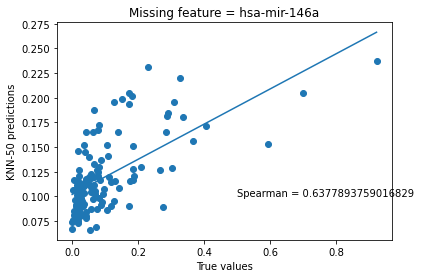

In [63]:
i = 0
plt.scatter(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]])
#plt.axis([0,1,0,1])
plt.xlabel("True values")
plt.ylabel("KNN-50 predictions")
plt.title("Missing feature = "+sp_sorted.index[i])
plt.text(0.5,0.1, "Spearman = "+str(sp_sorted[i]))

z = np.polyfit(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]], 1)
p = np.poly1d(z)
x_os = np.linspace(np.min(truth[sp_sorted.index[i]]), np.max(truth[sp_sorted.index[i]]), 1024)
plt.plot(x_os, p(x_os))

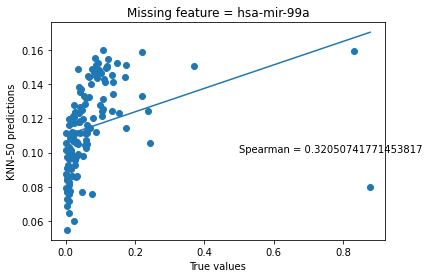

In [64]:
i = 125
plt.scatter(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]])
#plt.axis([0,1,0,1])
plt.xlabel("True values")
plt.ylabel("KNN-50 predictions")
plt.title("Missing feature = "+sp_sorted.index[i])
plt.text(0.5,0.1, "Spearman = "+str(sp_sorted[i]))

z = np.polyfit(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]], 1)
p = np.poly1d(z)
x_os = np.linspace(np.min(truth[sp_sorted.index[i]]), np.max(truth[sp_sorted.index[i]]), 1024)
plt.plot(x_os, p(x_os))

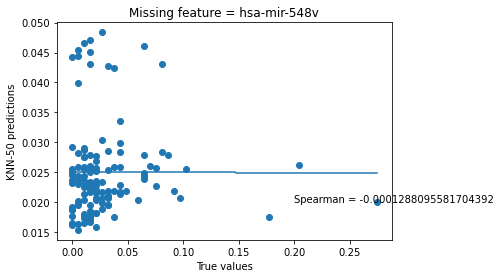

In [66]:
i = 256
plt.scatter(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]])
#plt.axis([0,1,0,1])
plt.xlabel("True values")
plt.ylabel("KNN-50 predictions")
plt.title("Missing feature = "+sp_sorted.index[i])
plt.text(0.2,0.02, "Spearman = "+str(sp_sorted[i]))

z = np.polyfit(truth[sp_sorted.index[i]], knn50_imp[sp_sorted.index[i]], 1)
p = np.poly1d(z)
x_os = np.linspace(np.min(truth[sp_sorted.index[i]]), np.max(truth[sp_sorted.index[i]]), 1024)
plt.plot(x_os, p(x_os))

# Testing TCGA classification with imputed data set

In [7]:
mrna_file = "../R/TCGA BRCA/mrna_top1000_scaled.csv"
meth_file = "../R/TCGA BRCA/meth_top1000_scaled.csv"
mirna_file = "../R/TCGA BRCA/mirna_anova_scaled.csv"

mrna = pd.read_csv(mrna_file, index_col="patient_id")
meth = pd.read_csv(meth_file, index_col="patient_id")
mirna = pd.read_csv(mirna_file, index_col="patient_id")
mrna.columns = [x.split("|")[1] for x in mrna.columns.tolist()]

# Getting labels
meta_csv = "../R/TCGA BRCA/PAM50_subtype.csv"
trte_partition_file = "../R/TCGA BRCA/trte_partition.txt"

meta = pd.read_csv(meta_csv, index_col="patient_id")
meta = meta.reindex(index=mirna.index)
#labels.iloc[:,0].value_counts()
label_dict = {'Normal':0, 'Basal':1, 'Her2':2, 'LumA':3, 'LumB':4}
labels = [label_dict[x] for x in meta.iloc[:,0].tolist()]


# Getting training and testing indices
patient_id = mirna.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

mrna_train = mrna.iloc[tr_idx]
meth_train = meth.iloc[tr_idx]
mirna_train = mirna.iloc[tr_idx]

mrna_test = mrna.iloc[te_idx]
meth_test = meth.iloc[te_idx]
mirna_test = mirna.iloc[te_idx]

In [10]:
# Merging data together
tcga_train = pd.merge(pd.merge(mrna_train, meth_train, left_index=True, right_index=True), mirna_train,  left_index=True, right_index=True)
tcga_test = pd.merge(pd.merge(mrna_test, meth_test, left_index=True, right_index=True), mirna_test,  left_index=True, right_index=True)
datatypes = ["mrna"]*mrna_train.shape[1] + ["meth"]*meth_train.shape[1] + ["mirna"]*mirna_train.shape[1]

# Remove test set values
mask = [x in ["meth", "mirna"] for x in datatypes]
tcga_test.loc[:,mask] = np.nan

# Vertically joining tcga and metabric data; missing features have NaN values
merged_data = pd.concat([tcga_train, tcga_test], keys=["train", "test"])

In [11]:
# Imputing the missing features in metabric data set
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(merged_data.loc["train"])

tcga_test_imputed = imputer.transform(merged_data.loc["test"])
tcga_test_imputed = pd.DataFrame(tcga_test_imputed, columns = merged_data.columns, index = merged_data.loc["test"].index)
tcga_test_imputed.head()

,10926,1602,585,91133,7083,56204,23171,85004,10411,130888,...,hsa-mir-217,hsa-mir-424,hsa-mir-581,hsa-mir-483,hsa-mir-3614,hsa-mir-16-1,hsa-mir-550a-2,hsa-mir-24-1,hsa-mir-508,hsa-mir-642a
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A1XV-01,0.214265,1.301372,1.688605,1.092357,-0.030847,1.754900,0.380510,1.242987,-0.458785,1.277053,...,-0.087259,0.080030,0.225233,-0.056830,-0.117501,-0.036690,-0.151618,-0.205418,-0.177974,0.195600
TCGA-E9-A1N3-01,0.193769,2.186939,0.898351,-1.802525,0.385683,0.448363,-0.314121,1.190404,0.045696,1.812918,...,-0.072203,0.042323,0.183445,-0.076312,-0.115678,-0.036235,-0.131749,-0.315787,-0.147574,0.131400
TCGA-D8-A1XG-01,-0.141184,1.272149,0.261419,0.534051,-0.406742,0.455924,-0.135788,1.420829,0.041171,-0.091375,...,-0.050710,0.039622,0.116585,-0.068481,-0.117170,-0.131322,-0.159155,-0.141346,-0.121866,-0.094154
TCGA-E9-A5UO-01,0.195732,0.858029,4.600256,1.042411,1.366650,-0.221751,0.495542,-0.245326,-1.089252,0.395734,...,0.023956,-0.188210,-0.109067,-0.060168,-0.073902,-0.091439,-0.172173,-0.190537,-0.069838,0.020611
TCGA-C8-A26Z-01,0.242619,1.302092,2.069561,-1.575360,-0.392501,-0.143493,0.247768,1.204553,0.199127,-0.155463,...,-0.079507,0.206891,0.024653,-0.072653,-0.089320,-0.065838,-0.113249,0.042603,-0.121560,-0.027113


In [12]:
# Vertically joining tcga_train and tcga_test_imputed data
complete_data = pd.concat([tcga_train, tcga_test_imputed])

# Separating the omics
mask = [x=="mrna" for x in datatypes]
mrna = complete_data.loc[:, mask]

mask = [x=="meth" for x in datatypes]
meth = complete_data.loc[:, mask]

mask = [x=="mirna" for x in datatypes]
mirna = complete_data.loc[:, mask]

In [14]:
# Getting labels
meta_csv = "../R/TCGA BRCA/PAM50_subtype.csv"
trte_partition_file = "../R/TCGA BRCA/trte_partition.txt"

meta = pd.read_csv(meta_csv, index_col="patient_id")
meta = meta.reindex(index=mirna.index)
#labels.iloc[:,0].value_counts()
label_dict = {'Normal':0, 'Basal':1, 'Her2':2, 'LumA':3, 'LumB':4}
labels = [label_dict[x] for x in meta.iloc[:,0].tolist()]


# Getting training and testing indices
patient_id = mirna.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

In [15]:
print(all(mrna.index == meth.index))
print(all(meth.index == mirna.index))
print(all(mrna.index == meta.index))

True
True
True


In [16]:
SEED = "random"

doSMOTE = True 

# Training parameters
num_epoch = 850
test_interval = 50
lr = 5e-4
weight_decay = 1e-3
dropout = 0.25
adj_parameter = 8 # average number of edge per node in adj matrix

VERBOSE = 1 #0, only print final result; 1, only testing result; 2, training and testing result
OUTPUT_FILES = False #Boolean to determine whether to output loss and metrics as csv files
REPEATS = 1 #Integer, how many times to independently train the model
feature_extract = []

In [18]:
import sys
sys.path.append('../')
from experimental import process, train

data_list = [mrna, meth, mirna]
labels = np.array(labels)
indices = (tr_idx, te_idx)

GCN_names = ["mRNA", "meth", "mirna"]
COMBINER = False

data = process(data_list, labels, indices, SEED=SEED)

SEED =  20505


In [19]:
loss, metrics, _, _ = train(data, label_dict=label_dict, GCN_names=GCN_names, COMBINER=COMBINER,
        SEED=SEED, num_epoch=num_epoch, test_interval=test_interval, lr=lr, weight_decay=weight_decay, 
        dropout=dropout, adj_parameter=adj_parameter, VERBOSE=VERBOSE,
        #RUN_TITLE=RUN_TITLE, RUN_TITLE_SHORT=RUN_TITLE_SHORT,
        OUTPUT_FILES=OUTPUT_FILES, feature_extract=feature_extract)

2021-05-30 23:40:33.660153 


SEED =  39605


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



Training...

Test: Epoch 0
Train Accuracy: 0.1990   Test ACC: 0.4837
Train F1: 0.1447         Test F1: 0.3154

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
Normal 	           0.2000              0.5646              0.1359              0.0000
Basal 	           0.2000              0.0239              0.1522              0.0000
Her2 	           0.2000              0.0526              0.0543              0.0000
LumA 	           0.2000              0.0287              0.4837              1.0000
LumB 	           0.2000              0.3254              0.1739              0.0000


Test: Epoch 50
Train Accuracy: 0.7139   Test ACC: 0.5000
Train F1: 0.7047         Test F1: 0.4176

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------



Test: Epoch 600
Train Accuracy: 0.9053   Test ACC: 0.7880
Train F1: 0.9032         Test F1: 0.7975

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
Normal 	           0.2000              0.9617              0.1359              0.8000
Basal 	           0.2000              0.9665              0.1522              0.9643
Her2 	           0.2000              1.0000              0.0543              0.8000
LumA 	           0.2000              0.7512              0.4837              0.7079
LumB 	           0.2000              0.8469              0.1739              0.8438


Test: Epoch 650
Train Accuracy: 0.8967   Test ACC: 0.7880
Train F1: 0.8945         Test F1: 0.7968

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
Normal 	  

<AxesSubplot:>

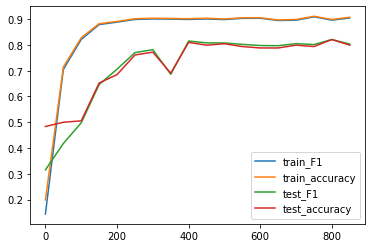

In [20]:
metrics.plot(y = ["train_F1", "train_accuracy", "test_F1", "test_accuracy"])

## CITE-Seq - Imputing Surface Protein Values

In [1]:
# Loading necessary libraries and functions
import sys
sys.path.append('../')
from main import train_model
from experimental import process, train
import pandas as pd
import numpy as np

# File locations
rna_file = "../../CITEseq_BMNC/rna.csv"
adt_file = "../R/CITE_Seq_BMNC/adt.csv"
adt_xgboost_file = "../R/CITE_Seq_BMNC/adt_xgboost.csv"
adt_ctpnet_file = "../R/CITE_Seq_BMNC/adt_ctpnet.csv"
meta_file = "../R/CITE_Seq_BMNC/cell_type.csv"
trte_partition_file = "../R/CITE_Seq_BMNC/trte_partition.txt"

In [2]:
labels = pd.read_csv(meta_file, index_col="cell_id")
label_dict = dict(zip(set(labels["cell_type"]), range(len(set(labels["cell_type"])))))

rna = pd.read_csv(rna_file, index_col="cell_id")
adt = pd.read_csv(adt_file, index_col="cell_id")
meta = pd.read_csv(meta_file, index_col="cell_id")

In [3]:
# Getting training and testing indices
patient_id = rna.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

rna_train = rna.iloc[tr_idx,:]
rna_test = rna.iloc[te_idx,:]

adt_train = adt.iloc[tr_idx,:]
adt_test = adt.iloc[te_idx,:]

meta_train = meta.iloc[tr_idx,:]
meta_test = meta.iloc[te_idx,:]

In [4]:
print(rna_train.shape)
print(rna_test.shape)
print(adt_train.shape)
print(adt_test.shape)
print(meta_train.shape)
print(meta_test.shape)

(24537, 2000)
(6135, 2000)
(24537, 25)
(6135, 25)
(24537, 1)
(6135, 1)


In [7]:
# Merging data together
bmnc_train = pd.merge(rna_train, adt_train,  left_index=True, right_index=True)
bmnc_test = pd.merge(rna_test, adt_test,  left_index=True, right_index=True)
datatypes = ["rna"]*rna_train.shape[1] + ["adt"]*adt_train.shape[1]

# Train Validation split
from sklearn.model_selection import train_test_split
bmnc_train, bmnc_val, meta_train, meta_val = train_test_split(bmnc_train, meta_train, test_size = 0.2, random_state = 42, stratify = meta_train)

In [8]:
print(bmnc_train.shape)
print(bmnc_val.shape)
print(meta_train.shape)
print(meta_val.shape)

(19629, 2025)
(4908, 2025)
(19629, 1)
(4908, 1)


In [25]:
# A mixture of oversampling and undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
SEED=42

# Setting the target so that the data is undersampled so that every cell_type that has more than 200 samples is reduced to 200
target = meta_train["cell_type"].value_counts().to_dict()
# for key in target:
#     target[key] = min(target[key],200)

# under = RandomUnderSampler(random_state=SEED, sampling_strategy=target)
# bmnc_smol, meta_smol = under.fit_resample(bmnc_train, meta_train["cell_type"])

# Setting the target so that cell_types with fewer than 200 samples are oversampled to 200
for key in target:
    target[key] = max(target[key], 400)
smote = SMOTE(random_state=SEED, sampling_strategy=target)

bmnc_smol, meta_smol = smote.fit_resample(bmnc_train, meta_train["cell_type"])

# Remove test set values
mask = [x == "adt" for x in datatypes]
bmnc_test.loc[:,mask] = np.nan

# Vertically joining tcga and metabric data; missing features have NaN values
merged_data = pd.concat([bmnc_smol, bmnc_test], keys=["train", "test"])

In [26]:
print(merged_data.loc["train"].shape)
print(merged_data.loc["test"].shape)
print(merged_data.shape)
# print(target)
# meta_train["cell_type"].value_counts().to_dict()

(23046, 2025)
(6135, 2025)
(29181, 2025)


In [27]:
merged_data.loc["train"].iloc[:,1998:2024]

,DCAF6,HSPA5,CD11a,CD11c,CD123,CD127-IL7Ra,CD14_y,CD16,CD161,CD19,...,CD34_y,CD38_y,CD4,CD45RA,CD45RO,CD56,CD57,CD69,CD79b,CD8a
0,-0.198513,-0.439985,1.239456,1.542844,0.304576,-0.585967,1.896837,-0.352113,-0.463837,-0.435394,...,-0.051925,1.455781,0.078905,-0.660133,-0.215179,-0.421130,-0.309522,0.986004,-0.604890,-0.525477
1,-0.198513,-0.439985,0.566264,1.292850,-0.364776,-0.690042,1.232005,-0.187949,-0.452038,-0.477773,...,-0.098578,0.897822,-0.205752,-1.045714,0.558074,0.092879,-0.049711,0.874582,-0.401011,-0.377808
2,-0.198513,-0.439985,1.293878,0.189046,0.644573,-0.530297,-0.700479,-0.315592,-0.211823,-0.625066,...,-0.065499,1.457837,0.013012,0.505487,-0.511820,0.790644,0.035895,-0.769587,-0.309351,-0.604059
3,-0.198513,-0.439985,-0.255461,-0.356770,0.287513,-0.681016,-0.316605,-0.137583,-0.433480,-0.405002,...,5.008456,0.265012,-0.138734,-0.899821,-0.808031,-0.215277,-0.012934,0.671094,-0.352017,0.274901
4,-0.198513,-0.439985,0.442987,-0.743058,-0.512777,-0.553842,-0.522209,-0.288209,-0.561713,-0.530291,...,-0.370304,0.945898,-0.955748,-1.311928,1.400625,-0.144416,-0.930047,-1.256666,-0.729783,2.105486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23041,-0.198513,1.217353,0.993537,-0.548507,5.951253,-1.022809,-0.249660,0.074423,-0.479875,-0.444658,...,0.755283,1.082143,0.726102,0.469172,-0.930959,-0.713587,0.116038,-0.108649,-0.294300,-0.610201
23042,-0.198513,1.854702,0.056198,-0.572470,5.853779,-0.950050,-0.488874,-0.291174,-0.583335,-0.190879,...,0.065324,1.692805,0.944137,0.465887,-0.614118,0.178205,-0.113053,-0.253886,-0.259373,-0.619354
23043,-0.198513,1.573650,0.739574,-0.705343,5.972257,-1.073269,-0.712758,-0.382537,0.010195,-0.451525,...,1.122728,1.487553,0.093061,-0.114205,-0.303635,-0.393497,-0.630852,0.661482,-0.578569,0.194625
23044,-0.198513,-0.439985,0.241251,-0.751520,6.711465,-0.847119,-0.398803,-0.000116,-0.241894,-0.196021,...,-0.041088,0.447419,1.210539,1.065807,-0.999003,0.422825,0.034235,-0.255710,-0.392804,-0.769674


In [28]:
merged_data.loc["test"].iloc[:,1998:2024]

,DCAF6,HSPA5,CD11a,CD11c,CD123,CD127-IL7Ra,CD14_y,CD16,CD161,CD19,...,CD34_y,CD38_y,CD4,CD45RA,CD45RO,CD56,CD57,CD69,CD79b,CD8a
b_CGTAGGCTCGAATGCT-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b_CATCAGAAGACCTTTG-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_TCAGCAATCCTGCCAT-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_ATGCGATTCAGCTCGG-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_TGAAAGAGTAAGAGGA-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_TGTATTCGTCGAGATG-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_CTCCTAGTCCCTCAGT-1,2.112650,0.604961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b_CCACCTATCACAACGT-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b_ACGGGTCCAGGAATCG-1,-0.198513,-0.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Imputing the missing features in metabric data set
from sklearn.impute import KNNImputer

neighbors = [1]
for n in neighbors:
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(merged_data.loc["train"])

    bmnc_test_imputed = imputer.transform(merged_data.loc["test"])
    bmnc_test_imputed = pd.DataFrame(bmnc_test_imputed, columns = merged_data.columns, index = merged_data.loc["test"].index)
bmnc_test_imputed.head()

In [ ]:
bmnc_test_imputed.shape

In [16]:
mask = [x == "adt" for x in datatypes]

test_set = pd.merge(rna_test, adt_test,  left_index=True, right_index=True)
truth = test_set.loc[:,mask]
knn50_imp = bmnc_test_imputed.loc[:,mask]
print(truth.shape)
print(knn50_imp.shape)

sp_score = knn50_imp.corrwith(truth, method="spearman")

order = sp_score.abs().sort_values(ascending = False)
sp_sorted = sp_score[order.index]

(6135, 25)
(6135, 25)


In [38]:
sp_sorted
# This one is using n_neighbors=100

CD14_y         0.742123
CD19           0.699847
CD11a          0.671292
CD11c          0.662438
CD56           0.635523
CD79b          0.627087
CD16           0.623880
CD123          0.557225
CD161          0.538561
CD45RA         0.528588
CD3            0.512949
CD27           0.494352
CD34_y         0.491450
CD4            0.488426
CD69           0.452834
CD8a           0.451158
CD28           0.449589
HLA.DR         0.439631
CD38_y         0.413978
CD278-ICOS     0.412415
CD127-IL7Ra    0.399727
CD45RO         0.341147
CD197-CCR7     0.310220
CD57           0.270680
CD25           0.174208
dtype: float64

### Getting scores for ADT imputed by other methods

In [1]:
# Loading necessary libraries and functions
import pandas as pd
import numpy as np

# File locations
rna_file = "../../CITEseq_BMNC/rna.csv"
adt_file = "../R/CITE_Seq_BMNC/adt.csv"
adt_xgboost_file = "../R/CITE_Seq_BMNC/adt_xgboost.csv"
adt_ctpnet_file = "../R/CITE_Seq_BMNC/adt_ctpnet.csv"
meta_file = "../R/CITE_Seq_BMNC/cell_type.csv"
trte_partition_file = "../R/CITE_Seq_BMNC/trte_partition.txt"

adt = pd.read_csv(adt_file, index_col="cell_id")
xgboost = pd.read_csv(adt_xgboost_file, index_col="cell_id")
ctpnet = pd.read_csv(adt_ctpnet_file, index_col="cell_id")

# Getting training and testing indices
patient_id = adt.index.to_numpy()
with open(trte_partition_file, 'r') as f:
    lines = f.readlines()

tr_patient_id_list = lines[1].strip().split(',')
te_patient_id_list = lines[3].strip().split(',')
tr_idx = [np.where(patient_id == pid)[0][0] for pid in tr_patient_id_list]
te_idx = [np.where(patient_id == pid)[0][0] for pid in te_patient_id_list]
te_idx = sorted(te_idx)

adt_test = adt.iloc[te_idx,:]
xgboost_test = xgboost.iloc[te_idx,:]
ctpnet_test = ctpnet.iloc[te_idx,:]

In [4]:
print(adt_test.shape)
print(xgboost_test.shape)
print(ctpnet_test.shape)

(6135, 25)
(6135, 25)
(6135, 24)


In [15]:
print(set(adt.columns))
print()
print(set(ctpnet.columns))
print()
print(set(xgboost.columns))
print()
print(set(adt.columns) - set(ctpnet.columns))
print()
print(set(ctpnet.columns) - set(adt.columns))
print()
print(set(adt.columns) - set(xgboost.columns))

{'CD34', 'CD79b', 'CD25', 'CD28', 'CD27', 'CD16', 'CD11c', 'CD19', 'CD8a', 'CD56', 'CD197-CCR7', 'CD57', 'CD69', 'CD4', 'CD38', 'HLA.DR', 'CD278-ICOS', 'CD14', 'CD123', 'CD45RA', 'CD11a', 'CD3', 'CD161', 'CD127-IL7Ra', 'CD45RO'}

{'CD34', 'CD79b', 'CD28', 'CD27', 'CD11c', 'CD16', 'CD19', 'CD56', 'CD57', 'CD69', 'CD8', 'CD4', 'CD38', 'HLA.DR', 'CD278-ICOS', 'CD14', 'CD123', 'CD45RA', 'CD11a', 'CD2', 'CD3', 'CD161', 'CD127-IL7Ra', 'CD45RO'}

{'CD34', 'CD79b', 'CD25', 'CD28', 'CD27', 'CD16', 'CD11c', 'CD19', 'CD8a', 'CD56', 'CD197-CCR7', 'CD57', 'CD69', 'CD4', 'CD38', 'HLA.DR', 'CD278-ICOS', 'CD14', 'CD123', 'CD45RA', 'CD11a', 'CD3', 'CD161', 'CD127-IL7Ra', 'CD45RO'}

{'CD25', 'CD197-CCR7', 'CD8a'}

{'CD2', 'CD8'}

set()


In [2]:
METHOD = "pearson"
cor_xgboost = adt_test.corrwith(xgboost_test, method=METHOD)
cor_ctpnet = adt_test.corrwith(ctpnet_test, method=METHOD)
pd.concat([cor_xgboost, cor_ctpnet], axis=1)

,0,1
CD11a,0.895952,0.759911
CD11c,0.958069,0.905097
CD123,0.880240,0.768460
CD127-IL7Ra,0.857226,0.836228
CD14,0.964076,0.887019
CD16,0.929260,0.856634
CD161,0.850247,0.747918
CD19,0.953024,0.885605
CD197-CCR7,0.415253,NaN
CD25,0.439223,NaN
